# Dataset Creation

We will create a dataset from different reddit posts related to 10 different sports

In [ ]:
import praw

# app credentials here
CLIENT_ID     = "8vq8BOenJg6KmSyMCCoGpw"
CLIENT_SECRET = "vHNwj4PVgzyPdIDOohjCi2l1hNgVGg"
USER_AGENT    = "final_proyect_script by /u/Any-Safety8002"

# initialize the client
reddit = praw.Reddit(
    client_id=CLIENT_ID,
    client_secret=CLIENT_SECRET,
    user_agent=USER_AGENT
)

subreddits = [
    "sports",
    "soccer",
    "nba",
    "nfl",
    "baseball",
    "hockey",
    "mma",
    "formula1",
    "tennis",
    "CFB"  # College Football
]

all_posts = []

i= 0
for sub in subreddits:
    subreddit = reddit.subreddit(sub)
    for post in subreddit.top(limit=1000):
        i+=1
        #print(i)
        all_posts.append({
            "subreddit": sub,
            "title": post.title,
#           "text": post.selftext,           # we decided to exclude this column as 95% of the rows are null
            "upvotes": post.score,
            "num_comments": post.num_comments,
            "created_utc": post.created_utc,
            "id": post.id
        })


Version 7.7.1 of praw is outdated. Version 7.8.1 was released Friday October 25, 2024.


In [ ]:
import pandas as pd

df = pd.DataFrame(all_posts)
df.to_csv("reddit_sports_posts.csv", index=False)
print(f"Saved {len(df)} posts.")


Saved 9802 posts.


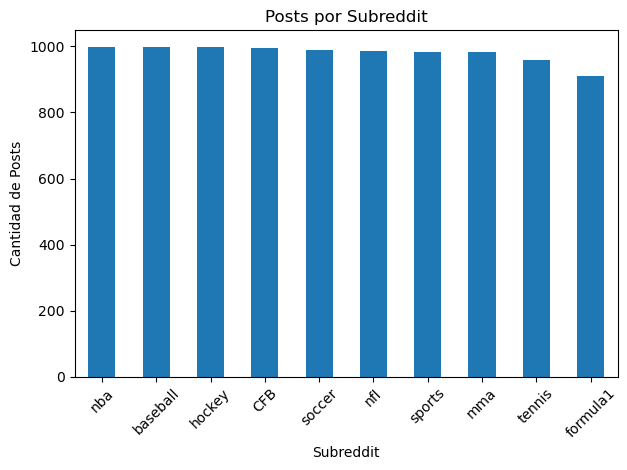

In [ ]:
# SOME PREVISUALIZATION

import matplotlib.pyplot as plt

df = pd.read_csv("reddit_sports_posts.csv")

post_counts = df['subreddit'].value_counts()
post_counts.plot(kind='bar', title='Posts per Subreddit')
plt.xlabel("Subreddit")
plt.ylabel("Amount of Posts")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


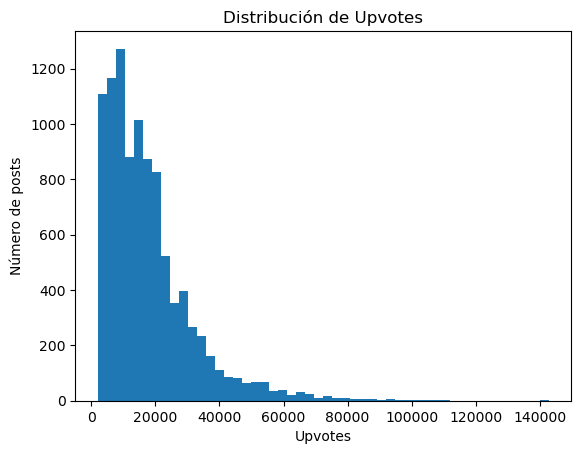

In [ ]:
plt.hist(df['upvotes'], bins=50)
plt.title("Upvote Distribution")
plt.xlabel("Upvotes")
plt.ylabel("Number of posts")
plt.show()


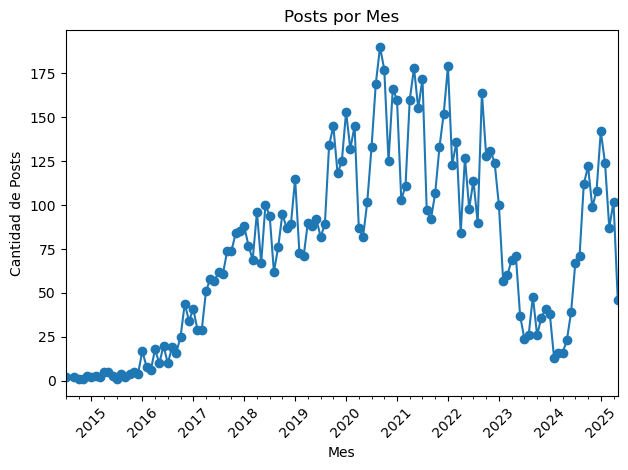

In [ ]:
df['created_utc'] = pd.to_datetime(df['created_utc'], unit='s')
df['month'] = df['created_utc'].dt.to_period('M')

df.groupby('month').size().plot(kind='line', marker='o', title='Posts per Month')
plt.xlabel("Month")
plt.ylabel("Amount of Posts")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Task 1: Text Preprocessing and vectorization

In [ ]:
from langdetect import detect, DetectorFactory
import pandas as pd

DetectorFactory.seed = 0

# First we check if there is some Null values inside Title or blank titles
df = df[df['title'].notnull() & (df['title'].str.strip() != "")]

# detect the language
def detect_lang(text):
    try:
        return detect(text)
    except:
        return "unknown"

df['lang'] = df['title'].apply(detect_lang)

# see languages
print(df['lang'].value_counts())



lang
en         9149
de          121
nl           46
it           45
da           44
af           35
no           34
ca           34
sl           30
id           29
fr           28
et           27
tl           25
ro           22
es           22
sv           20
pt           15
pl           12
cy            9
fi            9
so            8
hr            7
cs            5
unknown       5
lt            4
tr            4
sw            4
vi            4
sk            3
sq            2
Name: count, dtype: int64


In [ ]:
# Lets see some examples of no english titles
print(df[df['lang'] != 'en'][['title','lang']])

# We can see that in fact they are in english at least those that we see here so for now we are going to trust in that they are all in fact in english

                                                  title lang
26                         Don’t be like Nikola Kalinic   hr
46                                  Time Magazine cover   it
89                                  Foot sweep and knee   af
99                                 Devastating knockout   sv
129                              Lacrosse Goalie Scores   it
...                                                 ...  ...
9579  COLLEGE FOOTBALL’S SUPER BOWL, RUTGERS-KANSAS,...   de
9590                  [Official] Kansas hires Les Miles   fr
9675                                   AP Poll - Week 7   af
9752  [Postgame Thread] Colorado Defeats Colorado St...   pt
9785                                     Week 7 AP Poll   af

[653 rows x 2 columns]


In [ ]:
import nltk

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\snbas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\snbas\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\snbas\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\snbas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\snbas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
# Task 1: Text Preprocessing and vectorization

# Step 1: Implementation of a pipeline for the preprocessing of the texts.
# For this task you could use SpaCy, or any other library that you consider
# appropriate.

import pandas as pd
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# prepare NLTK tools
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

#
def clean_title(text):
    # lowercase and get rid of URL
    text = text.lower()
    text = re.sub(r'http\S+|www\.\S+', '', text)
    # tokenization
    tokens = nltk.word_tokenize(text)
    # filter and lemmatize
    cleaned = [
        lemmatizer.lemmatize(tok)
        for tok in tokens
        if tok.isalpha() and tok not in stop_words and len(tok) > 2
    ]
    return " ".join(cleaned)

# apply to df
df["clean_title"] = df["title"].apply(clean_title)


print(df[["title", "clean_title"]].head(10))


                                               title  \
0  Weightlifter promised his wife to win an Olymp...   
1  The LA Rams have an assistant coach whose job ...   
2  A Pelicans fan snuck on to the court for warmu...   
3  Jon Rahm skips the ball across the pond for th...   
4      "Just stay in there, you're done for tonight"   
5                     The Monterrey Stadium. Mexico.   
6  Dwyane Wade was very pleased with this no-look...   
7  Synced videos of the Eagles fan running into t...   
8   Boxing referee Steve Willis really loves his job   
9  Mario Balotelli absolutely filthy goal earlier...   

                                         clean_title  
0  weightlifter promised wife win olympic gold me...  
1  ram assistant coach whose job make sure head c...  
2  pelican fan snuck court warmups stretched put ...  
3                     jon rahm skip ball across pond  
4                                  stay done tonight  
5                           monterrey stadium mexico 

In [ ]:
# no need to still have those columns in the df

df.drop(columns=['title'], inplace=True)
df.drop(columns = ['lang'], inplace = True)

In [ ]:
df

,subreddit,upvotes,num_comments,created_utc,id,month,clean_title
0,sports,142825,2372,2017-12-16 13:24:22,7k6zaz,2017-12,weightlifter promised wife win olympic gold me...
1,sports,110244,2772,2019-01-21 21:14:03,aif0h8,2019-01,ram assistant coach whose job make sure head c...
2,sports,104147,2092,2018-01-29 17:06:07,7ttqeu,2018-01,pelican fan snuck court warmups stretched put ...
3,sports,102686,1696,2020-11-10 18:53:30,jrqxz3,2020-11,jon rahm skip ball across pond
4,sports,102038,1569,2018-02-28 17:18:55,80xq68,2018-02,stay done tonight
...,...,...,...,...,...,...,...
9797,CFB,4282,1405,2022-09-14 13:32:27,xe248s,2022-09,one foot notre dame head coach marcus freeman ...
9798,CFB,4273,1302,2018-11-28 15:31:05,a177hg,2018-11,select seriously
9799,CFB,4277,941,2022-09-09 13:13:11,x9v7s5,2022-09,nick saban favorite texas last time favorite w...
9800,CFB,4274,1108,2025-01-02 02:35:38,1hrjhma,2025-01,dan lanning refused blame seeding issue long l...


In [ ]:
# Step 2: Text vectorization. In this stage you will analyze the following
# vectorization schemes:

# – Classical BoW or TF-IDF representation.
# – Word2vec/Glove based representation or Doc2Vec vectorization.
# – Extraction of themes and vector representation of the documents using the LDA algorithm.

# In this cell we are going to do --> Classical BoW or TF-IDF representation.

import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# 0) Filter rows with valid cleaned title
df_model = df[df["clean_title"].notna() & (df["clean_title"].str.strip() != "")].copy()

# 1) Redefine y from this df_model
y_model = np.log1p(df_model["upvotes"].values)

# 2) In the loop, build X from df_model
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

for min_df in [5, 8, 10]:
    for max_df in [0.6, 0.7, 0.8]:
        tfidf = TfidfVectorizer(
            min_df=min_df,
            max_df=max_df,
            max_features=5000,
            ngram_range=(1,2)
        )
        X = tfidf.fit_transform(df_model["clean_title"])
        # Now X.shape[0] == y_model.shape[0]
        score = -cross_val_score(
            Ridge(),
            X, y_model,
            cv=5,
            scoring="neg_root_mean_squared_error"
        ).mean()
        print(min_df, max_df, X.shape, score)


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    min_df=5,
    max_df=0.7,
    max_features=5000,
    ngram_range=(1,2)
)

# Ajust and transform
X_tfidf = tfidf.fit_transform(df["clean_title"])

print("TF-IDF matrix shape:", X_tfidf.shape)


TF-IDF matrix shape: (9802, 4144)


In [ ]:
# top 10 words with highest idf (least common)
idf_scores = sorted(zip(tfidf.get_feature_names_out(), tfidf.idf_), key=lambda x: x[1], reverse=True)
print("Top 10 least common:", idf_scores[:10])


# top 10 words with lowest idf (most common)
idf_sorted = sorted(zip(tfidf.get_feature_names_out(), tfidf.idf_), key=lambda x: x[1])
print("Top 10 more common:", idf_sorted[:10])


Top 10 idf: [('ability', 8.398684271033671), ('accusing', 8.398684271033671), ('achilles', 8.398684271033671), ('acquire', 8.398684271033671), ('added', 8.398684271033671), ('admit', 8.398684271033671), ('admits', 8.398684271033671), ('afternoon', 8.398684271033671), ('aka', 8.398684271033671), ('alert', 8.398684271033671)]
10 más comunes: [('game', 3.373707859666758), ('team', 4.0377110455576215), ('first', 4.054878849179987), ('highlight', 4.10822482988528), ('year', 4.126658531574118), ('fan', 4.143071561215448), ('win', 4.221736180276361), ('player', 4.260854596871832), ('time', 4.321146827127952), ('get', 4.382301250281282)]


In [ ]:
# X_tfidf is a sparse matrix of shape (n_posts, n_features)
# Number of documents and features
n_docs, n_feats = X_tfidf.shape
print(f"{n_docs} docs, {n_feats} features")

# Density (percentage of non-zero cells)
density = X_tfidf.nnz / (n_docs * n_feats)
print(f"Density: {density:.4%}")

# the matrix is very sparse.

9802 docs, 4144 features
Densidad: 0.2018%


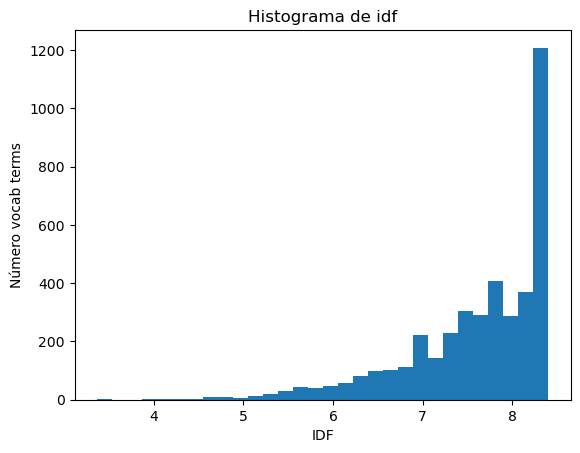

In [ ]:
import matplotlib.pyplot as plt

idf = tfidf.idf_
plt.hist(idf, bins=30)
plt.title("IDF Histogram")
plt.xlabel("IDF")
plt.ylabel("Number of vocab terms")
plt.show()


In [ ]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
import numpy as np

y = np.log1p(df['upvotes'])
model = Ridge(alpha=1.0)

scores = cross_val_score(model, X_tfidf, y, cv=5, scoring='neg_root_mean_squared_error')
print("RMSE CV (TF-IDF):", -scores.mean())


RMSE CV (TF-IDF): 0.9157024220372119


In [ ]:
# In this cell we are going to do --> Word2Vec/Glove based representation

import numpy as np
from gensim.models import Word2Vec
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

# — 1) Prepare the data
# Assumes that you already have in memory:
#   df with columns ['clean_title','upvotes']
#   y = np.log1p(df['upvotes'])  (same as before)

tokenized = [t.split() for t in df["clean_title"]]

# — 2) Train local Word2Vec model
w2v_model = Word2Vec(
    sentences=tokenized,
    vector_size=400,   # embedding dimension
    window=4,          # context window ±4 words
    min_count=4,       # ignore rare words (<4 occurrences)
    workers=4,
    epochs=20,
    seed=42
)

# — 3) Compute document vector as the mean of word vectors
def doc_vector(tokens):
    vecs = [w2v_model.wv[w] for w in tokens if w in w2v_model.wv]
    return np.mean(vecs, axis=0) if vecs else np.zeros(w2v_model.vector_size)

X_w2v = np.vstack([doc_vector(toks) for toks in tokenized])

# — 4) Quality info of the resulting matrix
n_docs, dim = X_w2v.shape
zero_vecs = np.sum(np.all(X_w2v == 0, axis=1))
print(f"Word2Vec matrix shape: {n_docs} docs × {dim} dims")
print(f"Zero‐vector docs: {zero_vecs} ({zero_vecs/n_docs:.2%})")

# — 5) Evaluate RMSE with Ridge + CV
model = Ridge(alpha=1.0)
scores = -cross_val_score(model, X_w2v, y, cv=5,
                          scoring="neg_root_mean_squared_error")
print(f"RMSE CV (Word2Vec): {scores.mean():.4f} ± {scores.std():.4f}")

# After tuning parameters, we conclude it performs worse than TF-IDF


Word2Vec matrix shape: 9802 docs × 400 dims
Zero‐vector docs: 59 (0.60%)
RMSE CV (Word2Vec): 0.9491 ± 0.4159


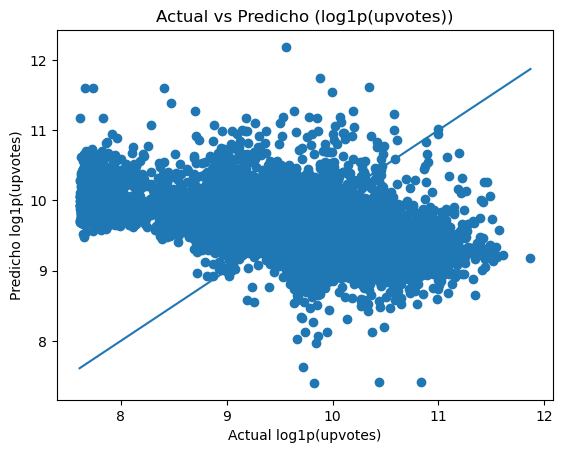

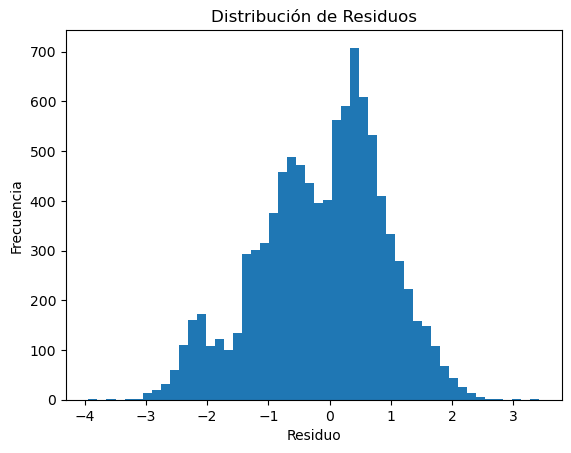

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_predict

# 1) Assume you already have in memory:
#    - df with 'upvotes' and 'clean_title'
#    - X_w2v: the matrix (9803×100) obtained earlier
y = np.log1p(df['upvotes'])

# 2) Predictions with cross-validation
model = Ridge(alpha=1.0)
preds = cross_val_predict(model, X_w2v, y, cv=5)

# 3) Scatter plot: actual vs predicted
plt.figure()
plt.scatter(y, preds)
plt.plot([y.min(), y.max()], [y.min(), y.max()])
plt.title("Actual vs Predicted (log1p(upvotes))")
plt.xlabel("Actual log1p(upvotes)")
plt.ylabel("Predicted log1p(upvotes)")
plt.show()

# 4) Residual histogram
residuals = y - preds
plt.figure()
plt.hist(residuals, bins=50)
plt.title("Residual Distribution")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()


Doc2Vec matrix shape: 9802 docs × 400 dims
Zero‐vector docs: 0 (0.00%)
RMSE CV (Doc2Vec): 0.8970 ± 0.3992


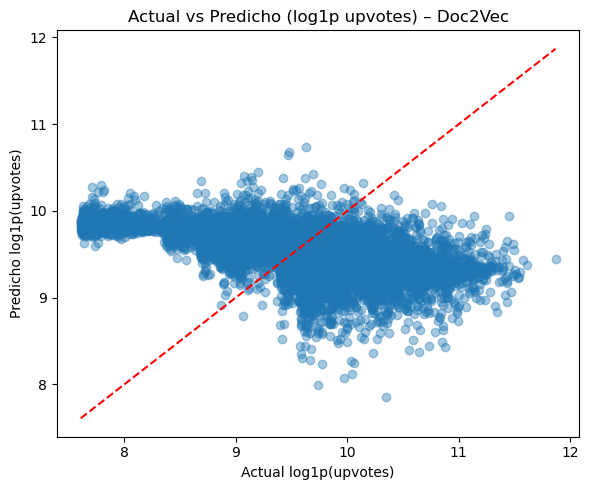

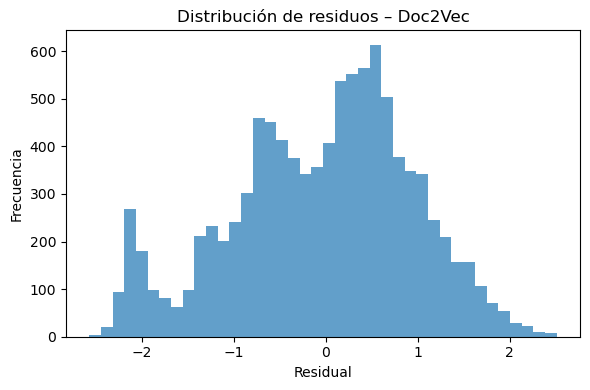

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score, cross_val_predict

# 1) Prepare tagged documents and target variable
docs = [
    TaggedDocument(words=title.split(), tags=[i])
    for i, title in enumerate(df["clean_title"])
]
y = np.log1p(df["upvotes"])

# 2) Train Doc2Vec model
d2v = Doc2Vec(
    vector_size=400,
    window=4,
    min_count=4,
    workers=4,
    epochs=20,
    seed=42
)
d2v.build_vocab(docs)
d2v.train(docs, total_examples=d2v.corpus_count, epochs=d2v.epochs)

# 3) Extract (n_docs × vector_size) matrix
X_d2v = np.vstack([d2v.dv[i] for i in range(len(docs))])

# 4) Matrix diagnostics
n_docs, dim = X_d2v.shape
zero_vecs = np.sum(np.all(X_d2v == 0, axis=1))
print(f"Doc2Vec matrix shape: {n_docs} docs × {dim} dims")
print(f"Zero‐vector docs: {zero_vecs} ({zero_vecs/n_docs:.2%})")

# 5) RMSE evaluation with Ridge + CV
model = Ridge(alpha=1.0)
scores = -cross_val_score(
    model, X_d2v, y, cv=5,
    scoring="neg_root_mean_squared_error"
)
print(f"RMSE CV (Doc2Vec): {scores.mean():.4f} ± {scores.std():.4f}")

# 6) Scatter actual vs predicted + residuals histogram
preds = cross_val_predict(model, X_d2v, y, cv=5)

plt.figure(figsize=(6,5))
plt.scatter(y, preds, alpha=0.4)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.title("Actual vs Predicted (log1p upvotes) – Doc2Vec")
plt.xlabel("Actual log1p(upvotes)")
plt.ylabel("Predicted log1p(upvotes)")
plt.tight_layout()
plt.show()

residuals = y - preds
plt.figure(figsize=(6,4))
plt.hist(residuals, bins=40, alpha=0.7)
plt.title("Residual Distribution – Doc2Vec")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

Best k: 20 coherence: 0.4555645292346392
LDA matrix shape: (9802, 20)


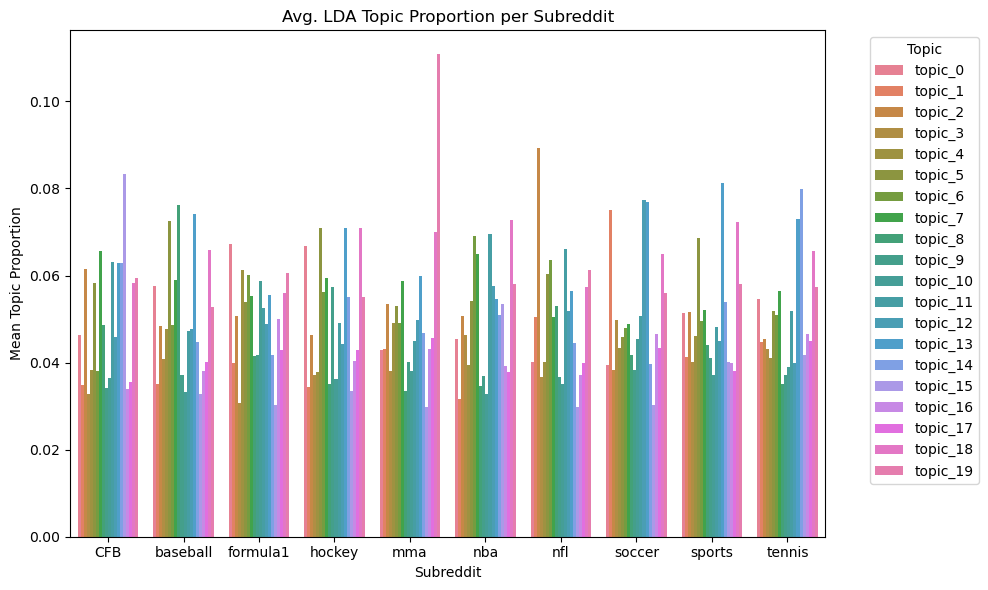

RMSE CV (LDA, k=20): 0.8626 ± 0.3944


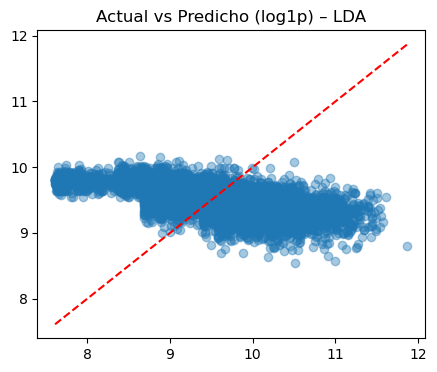

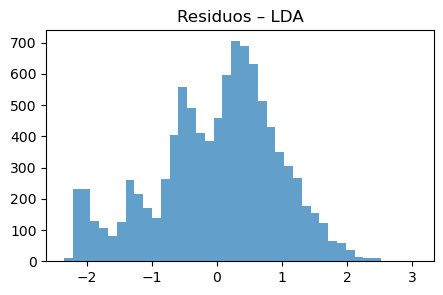

In [ ]:
# In this cell we perform extraction of themes and vector representation of the documents using the LDA algorithm


# 1) Tokenize + remove stopwords
texts = []
for doc in df["clean_title"]:
    tokens = [w for w in doc.split() if w.isalpha() and w not in stop_words]
    texts.append(tokens)

# 2) Bigrams
phrases = Phrases(texts, min_count=20, threshold=10)
bigram  = Phraser(phrases)
texts   = [bigram[t] for t in texts]

# 3) Dictionary & corpus
dictionary = Dictionary(texts)
dictionary.filter_extremes(no_below=5, no_above=0.7, keep_n=5000)
corpus = [dictionary.doc2bow(t) for t in texts]

# 4) Coherence sweep
coherences = []
for k in [5,10,15,20]:
    tmp_lda = LdaModel(corpus, id2word=dictionary, num_topics=k,
                       passes=10, random_state=42, alpha='auto', eta='auto')
    cm = CoherenceModel(model=tmp_lda, texts=texts,
                        dictionary=dictionary, coherence='c_v')
    coherences.append((k, cm.get_coherence()))
best_k, best_coh = max(coherences, key=lambda x: x[1])
print("Best k:", best_k, "coherence:", best_coh)

# 5) Train final LDA
lda = LdaModel(corpus, id2word=dictionary, num_topics=best_k,
               passes=30, iterations=300,
               alpha='auto', eta='auto', random_state=42)

# 6) Build doc–topic matrix
X_lda = np.array([
    [prob for _, prob in lda.get_document_topics(bow, minimum_probability=0)]
    for bow in corpus
])
print("LDA matrix shape:", X_lda.shape)

# Subreddit–topic importance plot
df_topics = pd.DataFrame(X_lda, columns=[f"topic_{i}" for i in range(X_lda.shape[1])])
df_topics['subreddit'] = df['subreddit'].values

subreddit_topic_importance = (
    df_topics
    .groupby('subreddit').mean()
    .reset_index()
)

df_melted = subreddit_topic_importance.melt(
    id_vars='subreddit',
    var_name='topic',
    value_name='importance'
)

plt.figure(figsize=(10,6))
sns.barplot(
    data=df_melted,
    x='subreddit', y='importance', hue='topic'
)
plt.title("Avg. LDA Topic Proportion per Subreddit")
plt.xlabel("Subreddit")
plt.ylabel("Mean Topic Proportion")
plt.legend(title="Topic", bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()

# save topic importances
subreddit_topic_importance.to_csv("subreddit_topic_importance.csv", index=False)

# 7) RMSE evaluation
y = np.log1p(df["upvotes"])
scores = -cross_val_score(Ridge(1.0), X_lda, y,
                          cv=5,
                          scoring="neg_root_mean_squared_error")
print(f"RMSE CV (LDA, k={best_k}): {scores.mean():.4f} ± {scores.std():.4f}")

# 8) Scatter and residuals
preds = cross_val_predict(Ridge(1.0), X_lda, y, cv=5)
plt.figure(figsize=(5,4))
plt.scatter(y, preds, alpha=0.4)
plt.plot([y.min(),y.max()],[y.min(),y.max()],'r--')
plt.title("Actual vs Predicted (log1p) – LDA")
plt.show()

res = y - preds
plt.figure(figsize=(5,3))
plt.hist(res, bins=40, alpha=0.7)
plt.title("Residuals – LDA")
plt.show()

# 9) Save dominant topic for each document
dominant_topics = [max(lda.get_document_topics(bow), key=lambda x:x[1])[0]
                   for bow in corpus]
df['dominant_topic'] = dominant_topics
df.to_csv("sports_titles_with_topics.csv", index=False)

In [ ]:
# THIS IS A SMALL DASHBOARD SECTION, DIFFERENT FROM THE MAIN DASHBOARD

# 2) Import and prepare the visualization
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# 3) Enable rendering in the notebook
pyLDAvis.enable_notebook()

# 4) Prepare the visualization object
vis = gensimvis.prepare(lda, corpus, dictionary)

# 5) Show the dashboard
vis


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
19    -0.145237 -0.046623       1        1  6.788753
18     0.056513  0.013036       2        1  6.428934
13     0.016982 -0.125684       3        1  6.206777
5      0.141337 -0.018117       4        1  5.998794
11    -0.043311  0.209741       5        1  5.926405
2      0.139323  0.128952       6        1  5.749736
7      0.133210  0.000174       7        1  5.667710
12     0.080271  0.104396       8        1  5.198621
6     -0.097634 -0.222581       9        1  5.043336
14     0.127346 -0.094064      10        1  5.034803
0      0.081753  0.070700      11        1  4.966293
8      0.133588  0.030155      12        1  4.497598
4     -0.024636 -0.126473      13        1  4.422428
1     -0.180470  0.105518      14        1  4.418676
16    -0.126449  0.132516      15        1  4.079031
10    -0.151244  0.107093      16        1  4.031395
17    -0.132275  0.002448      17        1  4.014619
9      0.091709 -0.041321      18        1  3.988935
15     0.057877 -0.106842      19        1  3.830120
3     -0.158654 -0.123024      20        1  3.707037, topic_info=           Term        Freq       Total Category  logprob  loglift
544      defeat  418.000000  418.000000  Default  30.0000  30.0000
23          fan  497.000000  497.000000  Default  29.0000  29.0000
8           win  472.000000  472.000000  Default  28.0000  28.0000
1243  highlight  420.000000  420.000000  Default  27.0000  27.0000
223      season  304.000000  304.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
1005       rest   25.127756   29.798060  Topic20  -4.5805   3.1245
470        stop   45.291110   67.524777  Topic20  -3.9913   2.8956
1243  highlight   74.449188  420.979535  Topic20  -3.4943   1.5625
1446  liverpool   24.127420   40.073986  Topic20  -4.6211   2.7876
905      become   23.660943   58.557585  Topic20  -4.6406   2.3888

[839 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
201      12  0.966450          aaron
821       6  0.946998  aaron_rodgers
1485     16  0.958428           able
50       13  0.967848     absolutely
890       9  0.938548          abuse
...     ...       ...            ...
874      10  0.802805           yard
2274      8  0.957584           yeah
207      16  0.980999      yesterday
217       2  0.988961          young
1018      7  0.972104         zverev

[1074 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[20, 19, 14, 6, 12, 3, 8, 13, 7, 15, 1, 9, 5, 2, 17, 11, 18, 10, 16, 4])

# Task 2: Machine Learning model

In [ ]:
# BEGINING OF TASK 2.3

from sentence_transformers import SentenceTransformer
from sklearn.neighbors import NearestNeighbors
import pandas as pd
import numpy as np

# Load your dataset, ensure it has 'id' and 'clean_title' columns
df.to_csv("reddit_sports_posts.csv", index=False)
df = pd.read_csv("reddit_sports_posts.csv")[['id', 'clean_title']]
print("Dataset size:", df.shape)
df.head()

# 3.1) Remove missing titles or convert them to empty strings
df['clean_title'] = df['clean_title'].fillna("").astype(str)

# 3.2) Optionally: remove rows where clean_title is still empty after fillna
df = df[df['clean_title'].str.strip() != ""]

# 3.3) Keep only id and clean_title for the recommender
df = df[['id', 'clean_title']].reset_index(drop=True)
print("Dataset size after dropping empty titles:", df.shape)

# Encode all titles into dense embeddings
embedder = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = embedder.encode(
    df['clean_title'].tolist(),
    show_progress_bar=True
)
print("Embeddings shape:", embeddings.shape)

# Fit a NearestNeighbors model using cosine distance
knn = NearestNeighbors(n_neighbors=6, metric='cosine', algorithm='auto')
knn.fit(embeddings)

# Define a function that, given a post ID, returns the top-k similar posts
def recommend(post_id, df=df, embeddings=embeddings, knn=knn, k=5, max_sim=0.9):
    """
    Given a post_id, returns up to k similar posts with similarity < max_sim.
    """
    # 1) Find the query index
    idx_list = df.index[df['id'] == post_id].tolist()
    if not idx_list:
        raise ValueError(f"post_id {post_id} not found")
    idx = idx_list[0]

    # 2) Query k+1 neighbors (including the post itself)
    distances, indices = knn.kneighbors([embeddings[idx]], n_neighbors=k+1)
    distances = distances.flatten()
    indices   = indices.flatten()

    # 3) Build recommendations, skip the original post, and filter by similarity
    recs = []
    for dist, ind in zip(distances[1:], indices[1:]):
        sim = 1.0 - dist
        if sim < max_sim:
            recs.append({
                'recommended_id': df.loc[ind, 'id'],
                'similarity':     sim,
                'title':          df.loc[ind, 'clean_title']
            })
        # Stop once we have k valid recommendations
        if len(recs) == k:
            break

    return pd.DataFrame(recs)



Dataset size: (9784, 2)
Dataset size after dropping empty titles: (9784, 2)


Batches:   0%|          | 0/306 [00:00<?, ?it/s]

Embeddings shape: (9784, 384)


In [ ]:
import random

# 1) Pick 5 random IDs
random_ids = random.sample(df['id'].tolist(), 5)

# 2) For each, print both the ID and title, then show recommendations
for post_id in random_ids:
    # Look up the title
    title = df.loc[df['id'] == post_id, 'clean_title'].values[0]

    print(f"\n=== Query post ===")
    print(f"ID:    {post_id}")
    print(f"Title: \"{title}\"\n")

    # Display the 5 recommendations
    display(recommend(post_id, k=5))




=== Query post ===
ID:    1gobcjz
Title: "highlight giannis get jaylen brown"



,recommended_id,similarity,title
0,ernrie,0.731971,highlight jaylen brown murder lebron
1,ug76st,0.704801,highlight giannis throw backboard two handed jam
2,kc1fjk,0.696606,highlight giannis pull deep start preseason
3,oyob58,0.668822,highlight race finish giannis get freethrow
4,omisps,0.658999,highlight holiday rip away lob giannis slam



=== Query post ===
ID:    q6afb4
Title: "pelissero source jon gruden informed staff plan resign raider coach"



,recommended_id,similarity,title
0,qsju85,0.682259,pelliserro former raider coach jon gruden suin...
1,deh87x,0.620869,graziano source washington fired head coach ja...
2,k8jeki,0.610268,pelissero jet fired defensive coordinator greg...
3,7od651,0.570670,raider giving new head coach jon gruden contra...
4,q9hzjg,0.546458,profootballtalk league knew jon gruden email l...



=== Query post ===
ID:    qlfezg
Title: "busquets miraculously recovers injury dynamo recovers possession"



,recommended_id,similarity,title
0,r2wdfy,0.464946,artemi panarin throw glove brad marchand bench
1,glf3je,0.429758,lakers shaq destroying defender
2,1by8gwk,0.420851,bublik want play anymore give racket ball girl
3,d7ly0s,0.415799,incredible goalkeeper save egyptian league
4,oiuqlp,0.414394,harry kane kalvin phillips magically heal injury



=== Query post ===
ID:    pn5q25
Title: "conor mcgregor involved physical altercation machine gun kelly mtv award"



,recommended_id,similarity,title
0,ci6c1v,0.624073,conor mcgregor put kickboxing masterclass nate...
1,6t6auy,0.566204,dana released real footage maglianni conor spa...
2,6x629m,0.566117,mcgregor mayweather fight
3,8ctajc,0.555280,frank mir conor mcgregor bus attack randy cout...
4,6hadn8,0.551401,floyd mcgregor fight finalized



=== Query post ===
ID:    1jy8uhi
Title: "carlos alcaraz celebrating monte carlo win ball kid"



,recommended_id,similarity,title
0,tu75ah,0.685691,great sportsmanship gesture carlos alcaraz
1,trvosw,0.640511,carlos alcaraz one best point year
2,16dyr12,0.608859,time carlos alcaraz retire
3,16a34in,0.600958,carlos alcaraz half volley
4,1edfiwu,0.597358,carlos alcaraz warmup leading first round olym...


In [ ]:
# 1) Extract just the post IDs from your existing df
df_posts = df[['id']].drop_duplicates().reset_index(drop=True)
print("Number of unique posts:", len(df_posts))
df_posts.head()

Number of unique posts: 9784


,id
0,7k6zaz
1,aif0h8
2,7ttqeu
3,jrqxz3
4,80xq68


In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.neighbors import NearestNeighbors
import pandas as pd
import numpy as np
import praw

# 1) Initialize PRAW and your list of subreddits
reddit = praw.Reddit(
    client_id="8vq8BOenJg6KmSyMCCoGpw",
    client_secret="vHNwj4PVgzyPdIDOohjCi2l1hNgVGg",
    user_agent="final_proyect_script by /u/Any-Safety8002"
)

subreddits = [
    "sports", "soccer", "nba", "nfl", "baseball",
    "hockey", "mma", "formula1", "tennis", "CFB"
]

# 2) Pre-scrape only 50 posts per subreddit instead of 1000
all_posts = []
for sub in subreddits:
    # Get the TOP 50 posts from each subreddit
    for post in reddit.subreddit(sub).top(limit=50):
        all_posts.append({
            "subreddit": sub,
            "post_id":   post.id
        })

print("Total posts to process:", len(all_posts))  # should be 10 subreddits × 50 = 500

# 3) Iterate through the list, extract comments (limited), and store (user, post, 1)
interactions = []
total = len(all_posts)
for i, item in enumerate(all_posts, start=1):
    post_id = item["post_id"]
    sub     = item["subreddit"]
    # Progress update on the same line
    print(f"Processing {i}/{total} – r/{sub} post {post_id}", end="\r")

    submission = reddit.submission(id=post_id)
    # Only top-level comments, without expanding more_comments
    submission.comments.replace_more(limit=0)
    for comment in submission.comments[:20]:  # max 20 comments
        if comment.author:
            interactions.append((
                comment.author.name,
                post_id,
                1
            ))
# Newline after completion
print()

# 4) Build the DataFrame and remove duplicates
df_interactions = (
    pd.DataFrame(interactions, columns=['user_id','post_id','rating'])
      .drop_duplicates(['user_id','post_id'])
      .reset_index(drop=True)
)

print("Total interactions collected:", len(df_interactions))
df_interactions.head()



Total posts to process: 500
Processing 500/500 – r/CFB post pmec92v6gtdx
Total interactions collected: 8438


,user_id,post_id,rating
0,Vathsade,7k6zaz,1
1,sumajyrag,7k6zaz,1
2,unknown_human,7k6zaz,1
3,aec216,7k6zaz,1
4,ictoa88,7k6zaz,1


In [ ]:
# Cell 5: Sample “negative” (user,post) pairs to augment df_interactions
import random

# all_users from positives, all_posts from embedding df
all_users = df_interactions['user_id'].unique()
all_posts = df['id'].unique()

negatives = []
for user in all_users:
    pos = set(df_interactions.loc[df_interactions.user_id==user, 'post_id'])
    # sample same #negatives as positives, but never more than available
    negs = random.sample(list(set(all_posts) - pos), len(pos))
    for p in negs:
        negatives.append((user, p, 0))

df_neg = pd.DataFrame(negatives, columns=['user_id','post_id','rating'])
# combine positives + negatives
df_cf = pd.concat([df_interactions, df_neg], ignore_index=True)
print("Positives:", len(df_interactions), "Negatives:", len(df_neg))


Positives: 8438 Negatives: 8438


In [ ]:
import scipy.sparse as sp
from implicit.als import AlternatingLeastSquares
import numpy as np

In [ ]:
import scipy.sparse as sp

# 8.1) Create the mappings
user_codes = {u:i for i,u in enumerate(df_interactions['user_id'].unique())}
item_codes = {pid:i for i,pid in enumerate(df['id'].unique())}

# 8.2) Map your DataFrame to integer row/col indices
df_mat = df_interactions.copy()
df_mat['uid'] = df_mat['user_id'].map(user_codes)
df_mat['iid'] = df_mat['post_id'].map(item_codes)

# 8.3) Drop any rows where the mapping failed (NaN in uid or iid)
df_mat = df_mat.dropna(subset=['uid','iid']).astype({'uid':'int32','iid':'int32'})

# 8.4) Build your confidence data: c = 1 + alpha * preference
alpha = 10.0
conf_data = 1.0 + alpha * df_mat['rating'].astype(float)

# 8.5) Extract final row/col arrays
rows = df_mat['uid'].values
cols = df_mat['iid'].values
data = conf_data.values

# 8.6) Build the COO and convert to CSR
conf_matrix = sp.coo_matrix(
    (data, (rows, cols)),
    shape=(len(user_codes), len(item_codes))
).tocsr()

print("Confidence matrix shape:", conf_matrix.shape)
print("Number of nonzero entries:", conf_matrix.nnz)



Confidence matrix shape: (7663, 9784)
Number of nonzero entries: 8418


In [ ]:
# Cell 9 – Train ALS on the user×item matrix
from implicit.als import AlternatingLeastSquares

als = AlternatingLeastSquares(
    factors=50,
    regularization=0.01,
    iterations=20,
    use_gpu=False
)

als.fit(conf_matrix)

  0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
# Cell 10 — define ALS recommend function (fixed unpacking)
# Inverse maps:
inv_user = {i: u for u,i in user_codes.items()}
inv_item = {i: pid for pid,i in item_codes.items()}

def recommend_als(user_id, k=5):
    if user_id not in user_codes:
        raise ValueError(f"user {user_id!r} not in training set")
    uidx = user_codes[user_id]

    # returns (array_of_item_idxs, array_of_scores)
    item_idxs, scores = als.recommend(
        uidx,
        conf_matrix[uidx],
        N=k,
        filter_already_liked_items=True
    )
    # map back to your post IDs
    return [(inv_item[i], float(s)) for i,s in zip(item_idxs, scores)]

# quick smoke test
test_user = inv_user[ list(inv_user.keys())[0] ]  # pick a real user
print("ALS recs for", test_user, ":", recommend_als(test_user, k=5))

ALS recs for Vathsade : [('f8xgj0', 0.257108211517334), ('5sbt58', 0.24007248878479004), ('bdnvkl', 0.1996544450521469), ('req84r', 0.1996055394411087), ('euwixj', 0.19889704883098602)]


In [ ]:
precisions = []
for user in test_df['user_id'].unique():
    true_post = test_df.loc[test_df['user_id']==user, 'post_id'].iloc[0]
    recs = recommend_als(user, k=5)
    rec_ids = {pid for pid,_ in recs}
    precisions.append(int(true_post in rec_ids))

print("ALS Precision@5:", np.mean(precisions))

ALS Precision@5: 0.0


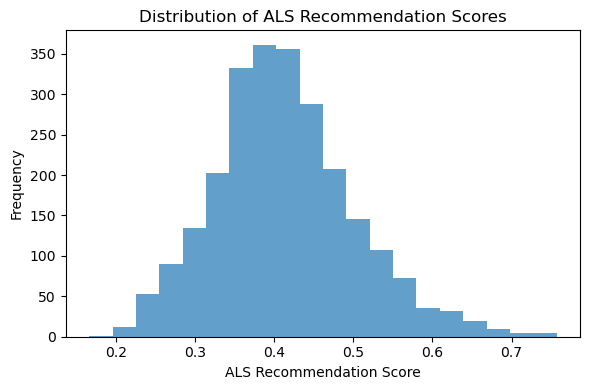

In [ ]:
als_scores = []
for user in test_inter['user_id'].unique():
    recs = recommend_als(user, k=5)
    als_scores.extend([score for _, score in recs])

plt.figure(figsize=(6,4))
plt.hist(als_scores, bins=20, alpha=0.7)
plt.xlabel('ALS Recommendation Score')
plt.ylabel('Frequency')
plt.title('Distribution of ALS Recommendation Scores')
plt.tight_layout()
plt.show()


In [ ]:
from surprise import Dataset, Reader, KNNBasic
from surprise.model_selection import train_test_split
import numpy as np

# 1) Load your df_interactions (positives only, rating=1)
reader = Reader(rating_scale=(0,1))
data   = Dataset.load_from_df(df_interactions[['user_id','post_id','rating']], reader)

# 2) Split into built-in train/test
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# 3) Train an item-based KNNBasic
sim_opts = {'name':'cosine', 'user_based': False}
algo_knn = KNNBasic(sim_options=sim_opts)
algo_knn.fit(trainset)

# 4) Build a lookup of test interactions per user for ranking-metrics
test_by_user = {}
for uid, iid, _ in testset:
    test_by_user.setdefault(uid, set()).add(iid)


Computing the cosine similarity matrix...
Done computing similarity matrix.


In [ ]:
# Collaborative Baseline: SVD

from surprise import SVD
from surprise.model_selection import cross_validate
import numpy as np

# 1) Instantiate the SVD algorithm (default hyperparameters)
algo_svd = SVD()

# 2) Perform 5-fold cross-validation on the full Dataset
#    measuring RMSE and MAE
cv_results = cross_validate(
    algo_svd,
    data,
    measures=['RMSE','MAE'],
    cv=5,
    verbose=True
)
# :contentReference[oaicite:0]{index=0}

# 3) Print out the average errors
mean_rmse = np.mean(cv_results['test_rmse'])
mean_mae  = np.mean(cv_results['test_mae'])
print(f"SVD Latent-Factor RMSE: {mean_rmse:.4f}")
print(f"SVD Latent-Factor MAE:  {mean_mae:.4f}")


Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.0242  0.0301  0.0306  0.0271  0.0291  0.0282  0.0023  
MAE (testset)     0.0097  0.0117  0.0121  0.0113  0.0119  0.0113  0.0008  
Fit time          0.06    0.05    0.07    0.05    0.06    0.06    0.01    
Test time         0.01    0.02    0.01    0.01    0.00    0.01    0.01    
SVD Latent-Factor RMSE: 0.0282
SVD Latent-Factor MAE:  0.0113
